# Binary Classification of Spirals

Binary Classification using CS231n Convolutional Neural Networks for Visual Recognition's `spirals`

> This classification dataset is constructed by taking a multi-dimensional standard normal distribution and defining classes separated by nested concentric multi-dimensional spheres such that roughly equal numbers of samples are in each class (quantiles of the distribution).

Note: 42 is the random_state that is used for replicability.

In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

## 1. Develop Dataset

Generate a random samples from a Gaussian distribution with 5 features and 8 classes. X1 contains the input data, and Y1 contains the corresponding class labels.

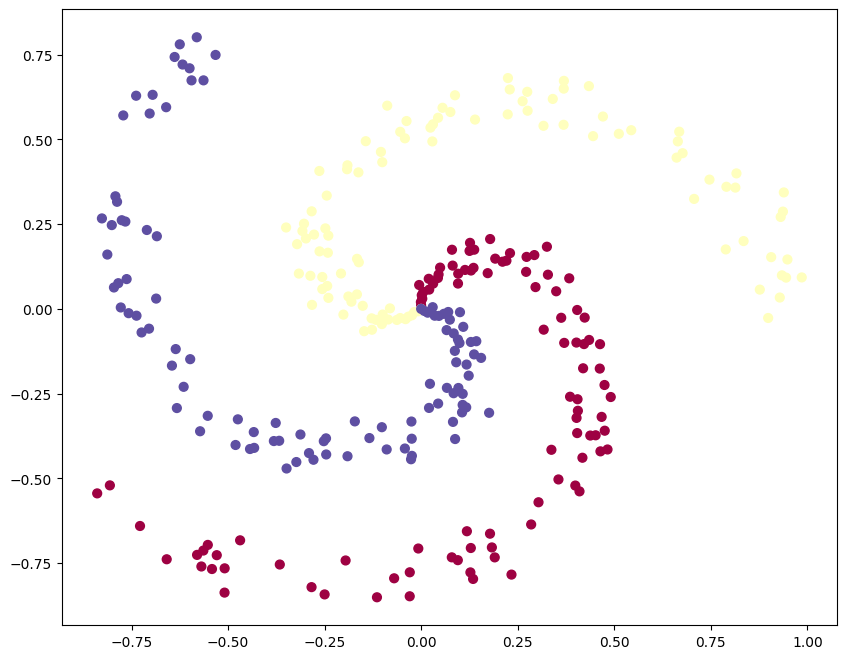

In [2]:
fig = plt.figure(figsize=(10, 8))

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

plt.show()

In [5]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

### Test & Train Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
len(X_train), len(y_train)

(240, 240)

## 2. Build Model

Device agnostic code

In [8]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
class Spiral_Classifier_V0(nn.Module):
  def __init__(self, input_features, output_features, hidden_state = 8):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_state),
        nn.ReLU(),
        nn.Linear(in_features = hidden_state, out_features = hidden_state),
        nn.ReLU(),
        nn.Linear(in_features = hidden_state, out_features = output_features)
    )
  def forward(self, x):
    return self.layer(x)

model_0 = Spiral_Classifier_V0(input_features = D, output_features = K, hidden_state = 6)
model_0.to(device)

Spiral_Classifier_V0(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=3, bias=True)
  )
)

Declare the model we want to train

Determine what the model returns without training

In [17]:
torch.manual_seed(42)
model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test.to(device)).squeeze()
  y_pred_probs = torch.softmax(y_logits, dim = 1)
  y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Create the loss and optimizer

### 3. Create a training and testing loop

In [18]:
# Send all data to GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [26]:
# Constants
EPOCHS = 1000
LEARNING_RATE = 0.1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = LEARNING_RATE)

In [29]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [32]:
for epoch in range(EPOCHS):
  model_0.train()

  # Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred_probs = torch.softmax(y_logits, dim = 1)
  y_preds = torch.argmax(y_pred_probs, dim = 1)

  # Calculate the Loss
  loss = loss_fn(y_logits, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing Loop
  model_0.eval()

  with torch.inference_mode():
    # Forward Pass
    y_test_logits = model_0(X_test).squeeze()
    y_test_pred_probs = torch.softmax(y_test_logits, dim = 1)
    y_test_preds = torch.argmax(y_test_pred_probs, dim = 1)

    # Calculate the loss
    test_loss = loss_fn(y_test_logits, y_test)
    acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.2f}, Test Loss: {test_loss:.2f}, Accuracy: {acc:.2f}")

Epoch: 0, Loss: 0.30, Test Loss: 0.31, Accuracy: 90.00
Epoch: 100, Loss: 0.28, Test Loss: 0.29, Accuracy: 90.00
Epoch: 200, Loss: 0.27, Test Loss: 0.28, Accuracy: 90.00
Epoch: 300, Loss: 0.26, Test Loss: 0.27, Accuracy: 90.00
Epoch: 400, Loss: 0.24, Test Loss: 0.25, Accuracy: 90.00
Epoch: 500, Loss: 0.26, Test Loss: 0.28, Accuracy: 88.33
Epoch: 600, Loss: 0.21, Test Loss: 0.22, Accuracy: 93.33
Epoch: 700, Loss: 0.16, Test Loss: 0.17, Accuracy: 93.33
Epoch: 800, Loss: 0.14, Test Loss: 0.15, Accuracy: 93.33
Epoch: 900, Loss: 0.13, Test Loss: 0.13, Accuracy: 93.33


In [33]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([[1., 0., 1.],
         [0., 0., 1.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 0., 1.],
         [1., 0., 1.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.]], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [34]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

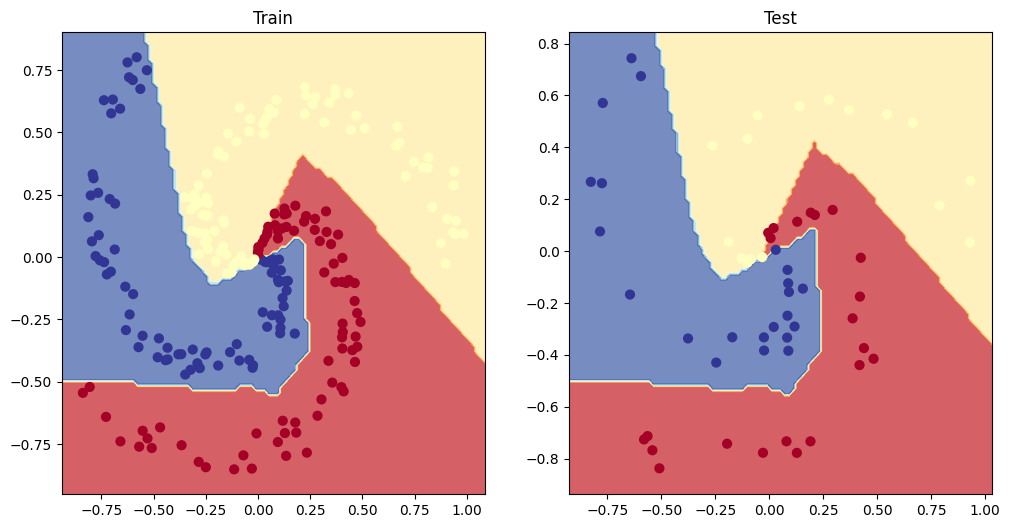

In [36]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)